In [3]:
cd ../

/Users/linafaik/Documents/projects/time-series-forecasting-models


In [4]:
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
import os

from nixtla import NixtlaClient
import shap
import matplotlib.pyplot as plt

from config import *
from src.data_processing import *
from src.metrics import *
from src.training import *
from src.viz import *

%load_ext autoreload
%autoreload 2


In [23]:
dir_output = "output/timegpt"
path_input="output/data_processed.gz"

H = 14 # forecast horizon
n_ts = 10

In [7]:
client = NixtlaClient(api_key=NIXTLA_API_KEY)

df = pd.read_csv(path_input)
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [8]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date,sales,weekday,wm_yr_wk,event_type_1,event_type_2,sell_price,event_sporting,event_cultural,event_national,event_religious
0,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-29,3,Saturday,11101,NaN,NaN,2.0,0,0,0,0
1,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-30,0,Sunday,11101,NaN,NaN,2.0,0,0,0,0
2,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-01-31,0,Monday,11101,NaN,NaN,2.0,0,0,0,0
3,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-01,1,Tuesday,11101,NaN,NaN,2.0,0,0,0,0
4,FOODS_1_001_CA_1_evaluation,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,2011-02-02,4,Wednesday,11101,NaN,NaN,2.0,0,0,0,0


## Train / Test Split

In [32]:
count_df = df[df["sales"]>0].groupby("id").size()

random_ts = np.random.choice(
    df[df['id'].isin(
        count_df[count_df>800].index.unique()
        )]["id"].unique(), 
    size=n_ts)
subset_df = df[df['id'].isin(random_ts)].copy()
train_df, test_df = split_train_test(subset_df, H)

print(f"{len(train_df)} rows for train")
print(f"{len(test_df)} rows for test")

19270 rows for train
140 rows for test


## Uncertainty quantification

In [33]:
id_col="id"
time_col="date"
target_col="sales"
finetune_steps = 10
finetune_loss = "rmse"
finetune_depth = 3
freq = "D"
model = "timegpt-1-long-horizon"

In [34]:
forecast_df = client.forecast(
    df=train_df[["date", "sales", "id"]],
    id_col=id_col,
    time_col=time_col,
    target_col=target_col,
    h=H,
    freq=freq,
    finetune_steps=finetune_steps,
    finetune_loss=finetune_loss,
    finetune_depth=finetune_depth, 
    model=model,
    date_features=True,
    date_features_to_one_hot=False,
    level=[80, 90]
)

forecast_df.head()

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['year', 'month', 'day', 'weekday']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


,id,date,TimeGPT,TimeGPT-hi-80,TimeGPT-hi-90,TimeGPT-lo-80,TimeGPT-lo-90
0,FOODS_1_032_CA_2_evaluation,2016-05-09,5.100850,8.561880,9.627643,1.639819,0.574056
1,FOODS_1_032_CA_2_evaluation,2016-05-10,4.823017,7.656291,8.629951,1.989744,1.016083
2,FOODS_1_032_CA_2_evaluation,2016-05-11,4.496989,8.341354,10.524794,0.652624,-1.530815
3,FOODS_1_032_CA_2_evaluation,2016-05-12,4.256443,7.939001,9.036331,0.573886,-0.523445
4,FOODS_1_032_CA_2_evaluation,2016-05-13,6.735807,10.668447,11.758533,2.803168,1.713082


In [35]:
fig = plot_forecast_with_ci(train_df, test_df, forecast_df, uid=random_ts[0], level=90)
fig.show()

## Shape value

In [36]:
columns_exog_features = ["sell_price", "event_cultural", "event_national", "event_religious", "event_sporting"]

forecast_df = client.forecast(
    df=train_df[["date", "sales", "id"]+columns_exog_features],
    X_df=test_df[["date", "id"]+columns_exog_features],
    id_col=id_col,
    time_col=time_col,
    target_col=target_col,
    h=H,
    freq=freq,
    finetune_steps=finetune_steps,
    finetune_loss=finetune_loss,
    finetune_depth=finetune_depth, 
    model=model,
    date_features=True,
    date_features_to_one_hot=False,
    clean_ex_first=True,
    feature_contributions=True
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Using future exogenous features: ['sell_price', 'event_cultural', 'event_national', 'event_religious', 'event_sporting', 'year', 'month', 'day', 'weekday']
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


In [37]:
shap_df = client.feature_contributions
shap_df.head()

,id,date,TimeGPT,sell_price,event_cultural,event_national,event_religious,event_sporting,year,month,day,weekday,base_value
0,FOODS_1_032_CA_2_evaluation,2016-05-09,2.847101,-0.363547,-0.004396,-0.001052,-0.025349,0.002655,0.659276,-0.316227,0.121936,-0.809970,3.583775
1,FOODS_1_032_CA_2_evaluation,2016-05-10,3.239904,-0.191351,-0.002726,-0.000239,-0.025747,0.002655,0.703484,-0.228869,-0.028842,-0.730975,3.742513
2,FOODS_1_032_CA_2_evaluation,2016-05-11,3.147784,-0.190175,-0.002890,0.000726,-0.026299,0.002655,0.694752,-0.203760,-0.057090,-0.698611,3.628475
3,FOODS_1_032_CA_2_evaluation,2016-05-12,3.441888,-0.105231,-0.002892,0.001301,-0.026299,0.002655,0.725255,-0.190857,-0.128587,-0.542606,3.709148
4,FOODS_1_032_CA_2_evaluation,2016-05-13,5.646378,0.069298,-0.008429,0.003850,-0.020966,0.003324,1.177297,-0.136053,0.034254,0.473455,4.050349


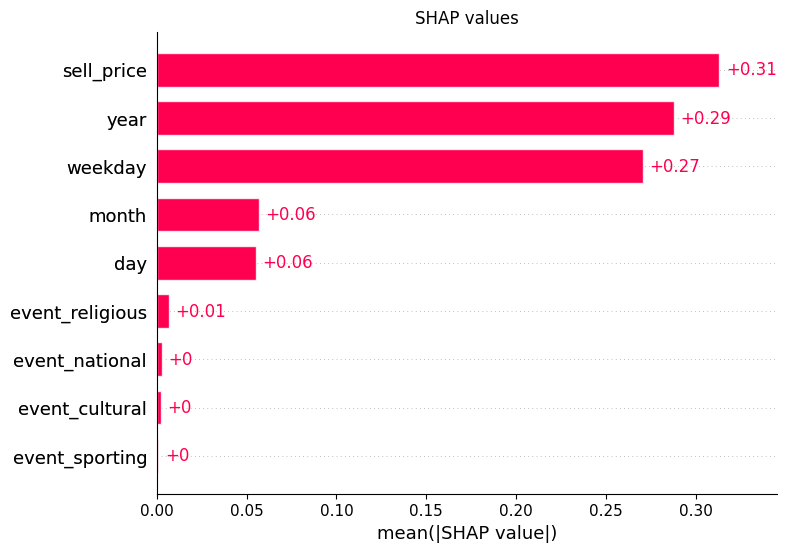

In [38]:
shap_columns = shap_df.columns.difference(['id', 'date', 'TimeGPT', 'base_value'])

shap_obj = shap.Explanation(
    values=shap_df[shap_columns].values,
    base_values=shap_df['base_value'].values,
    feature_names=shap_columns
)

shap.plots.bar(
    shap_obj,
    max_display=len(shap_columns),
    show=False
)

plt.title(f'SHAP values')
plt.show()

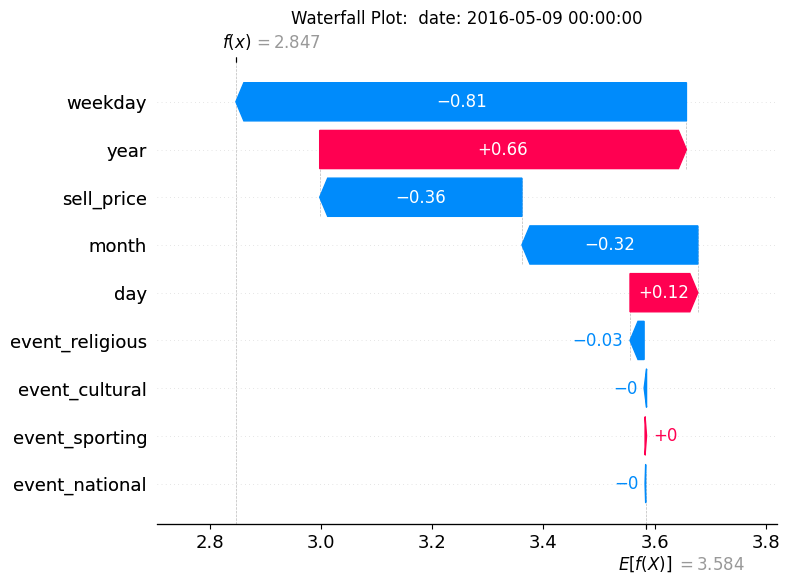

In [39]:
selected_ds = shap_df['date'].min()

filtered_df = shap_df[shap_df['date'] == selected_ds].iloc[:1]

shap_obj = shap.Explanation(
    values=filtered_df[shap_columns].values.flatten(),
    base_values=filtered_df['base_value'].values[0],
    feature_names=shap_columns
)

shap.plots.waterfall(shap_obj, show=False)

plt.title(f'Waterfall Plot:  date: {selected_ds}')
plt.show()